In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    IN_COLAB = False
else:
    drive.mount('/content/drive')
    IN_COLAB = True

In [2]:
if IN_COLAB:
    REF_PATH = "/content/drive/MyDrive/Project/"
else:
    REF_PATH = "../../../../data/"
REF_PATH += "Average pm25 per neighborhood BASELINE.csv"

In [3]:
TRIPS_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/NYC_Pilot2_PM_Part1.csv'
POLYGON_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/nyc_polygon.geojson'

In [4]:
import pandas as pd
import folium
import geopandas as gpd
from datetime import datetime
import numpy as np
from shapely.geometry import Polygon
import math
import matplotlib.pyplot as plt
from shapely import wkt

import h3

In [5]:
h3_resolution_min = 0
h3_resolution_max = 15
sampling_frequency = 0.6

In [6]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.longitude, trips.latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [7]:
reference_value = pd.read_csv(REF_PATH)
reference_value['geometry'] = reference_value['geometry'].apply(wkt.loads)
reference_value = gpd.GeoDataFrame(reference_value, crs='epsg:4326')
print(reference_value['neighborhood'].nunique())
print(len(reference_value['neighborhood']))

48
48


In [8]:
def calculate_mape(predicted_values, actual_values):
    # Calculate absolute differences
    absolute_diff = np.abs(actual_values - predicted_values)
    
    # Calculate percentage error
    percentage_error = absolute_diff / actual_values
    
    # Handle cases where actual values are 0 to avoid division by zero
    percentage_error = np.nan_to_num(percentage_error, nan=0, posinf=0)
    
    # Calculate mean percentage error
    mean_percentage_error = np.mean(percentage_error)
    
    # Convert mean percentage error to percentage
    mape = mean_percentage_error * 100
    
    return mape

In [9]:
def group_by_h3(df, h3_resolution):
    df['h3'] = df.apply(lambda x: h3.geo_to_h3(x.latitude, x.longitude, resolution=h3_resolution), axis=1)
    return df.groupby('h3')

In [10]:
def get_mape_h3(baseline, encoded):
    error = []
    h3_resolution = h3_resolution_min
    while h3_resolution <= h3_resolution_max:
        sampled_trips = group_by_h3(encoded, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True) #Stratified Sampling
        df_enc_pm25 = (sampled_trips
                          .groupby('h3')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())# Make a list of pm25 values for each h3 cell

        df_enc_pm25['average_pm25_value'] = df_enc_pm25['pm25_list'].apply(lambda x:sum(x)/len(x)) #Find the average pm25 value for each h3 cell
        df_enc_pm25.drop('pm25_list', axis = 1, inplace=True)
        sampled_trips_with_neighborhood_pm25 = pd.merge(sampled_trips, baseline, on='neighborhood', how='inner')
        sampled_trips_with_enc_geometry_pm25 = pd.merge(sampled_trips, df_enc_pm25, on='h3', how='inner')
        baseline_pm25 = sampled_trips_with_neighborhood_pm25["average_pm25_value"].values
        sampled_pm25  = sampled_trips_with_enc_geometry_pm25["average_pm25_value"].values
        mape = calculate_mape(sampled_pm25, baseline_pm25)
        error.append(mape) #Append to Error list
        h3_resolution += 1
    return error

In [11]:
MAPE_H3 = get_mape_h3(reference_value,trips)

In [12]:
MAPE_H3

[3.4047045007755106,
 3.4408112227016687,
 3.4463964587882847,
 3.4602309148000443,
 3.5879050380213835,
 3.605708360810067,
 3.0820976476208966,
 4.348299228748202,
 5.745095025156545,
 8.015497006959285,
 10.780067439422607,
 13.539229675205272,
 17.979585741596164,
 21.89159656075172,
 25.091998573928397,
 27.015550225768987]

<Figure size 640x480 with 0 Axes>

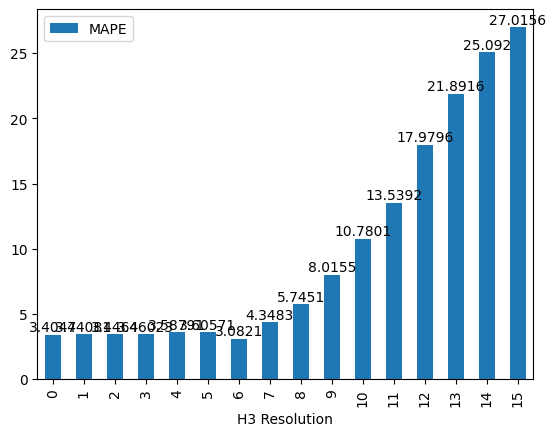

In [13]:
X_LABEL = 'H3 Resolution'
Y_LABEL = 'MAPE'
H3_Performance = pd.DataFrame({X_LABEL:list(range(h3_resolution_min, h3_resolution_max + 1)),
                               Y_LABEL: MAPE_H3})
plt.figure()
ax = H3_Performance.plot(kind='bar', x=X_LABEL, y=Y_LABEL)
ax.bar_label(ax.containers[0], color = 'black')
plt.show()